In [5]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
seed(1)

In [6]:
#Parameter Definitions
B = 1
A0 = 1

In [7]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [8]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [9]:
#Get Ground State Energy and Wavefuntion
def groundState(H):       
    #find ground state
    groundState= H.groundstate()
    return groundState[0],groundState[1]

In [10]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [11]:
#get randomized RBM parameters
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [13]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm

In [14]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [15]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [16]:
#Gradient Descent
def gradDescent(N, M,B,A0):
    par = ranRBMpar(N,M)
    H = hamiltonian(N, B, A0) 
    min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),full_output=True, retall = True, disp=True)
    #Ground State
    found_gs = RBM_ansatz(min[0],N, M)
    found_gs = found_gs.unit()
    #Ground State Energy
    found_gsEnergy =varEnergy(min[0], N, M,H)

    return min, found_gs, found_gsEnergy  

In [34]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr

In [35]:
#Run Gradient Descent with N=2, M=2
results = gradDescent(2, 2, B, A0)

Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 49
         Function evaluations: 2340
         Gradient evaluations: 130


In [36]:
#Comparison to evaluation
gs = groundState(hamiltonian(2, B, A0))[1]
gsEnergy = groundState(hamiltonian(2, B, A0))[0]
eng_err = err(results[1],gs,results[2],gsEnergy)[0]
waveFunction_err = err(results[1],gs,results[2],gsEnergy)[1]
print("Found Ground State: \n", results[1])
print("Actual Ground State: \n", gs)
print("Ground State Error: \n", waveFunction_err)
print("Found Ground State Energy: \n", results[2])
print("Actual Ground State Energy: \n", gsEnergy)
print("Ground State Energy Error: \n", eng_err)


Found Ground State: 
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 4.04723860e-04+6.66162653e-05j]
 [-2.55801490e-01-2.84626075e-01j]
 [ 6.17563685e-01+6.87145038e-01j]
 [ 4.09587314e-04-2.25838414e-04j]]
Actual Ground State: 
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.38268343]
 [ 0.92387953]
 [ 0.        ]]
Ground State Error: 
 1.9350398916540001e-07
Found Ground State Energy: 
 -0.9571063392886117
Actual Ground State Energy: 
 -0.9571067811865476
Ground State Energy Error: 
 4.4189793590998505e-07


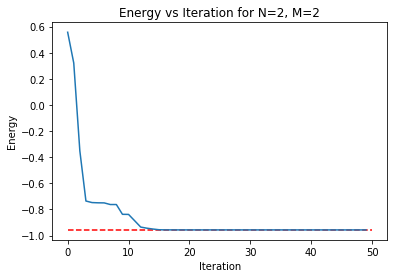

In [37]:
#plot energy vs iteration
numIter = len(results[0][5])
iter = np.arange(numIter)
energy = np.zeros(numIter)
for i in range(numIter):
    energy[i]= varEnergy(results[0][5][i],2, 2, hamiltonian(2, B, A0))
plt.plot(iter, energy)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration for N=2, M=2')
plt.hlines(gsEnergy,0,numIter, "r", linestyle = "--")
plt.show()
